In [1]:
using Plots, LinearAlgebra

---

# "Almost" Zero-Allocation Neural Network

In [6]:
module ZeroAllocationNN
using LinearAlgebra
export ZANN
mutable struct ZANN{T<:AbstractFloat}
    weights :: Vector{Matrix{T}}
    biases :: Vector{Vector{T}}
    
    weighted_inputs :: Vector{Matrix{T}}
    activations :: Vector{Matrix{T}}
        
    nabla_ws :: Vector{Matrix{T}}
    nabla_bs :: Vector{Vector{T}}
    
    function ZANN(::Type{T}, layer_dims) where {T<:AbstractFloat}
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(T, layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(T, layer_dims[i]))
        end
        return new{T}(
            weights,
            biases,
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Matrix{T}}(undef, length(layer_dims)),
            Vector{Matrix{T}}(undef, length(layer_dims) - 1),
            Vector{Vector{T}}(undef, length(layer_dims) - 1)
        )
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN{T}, x :: Matrix{T}) where {T}
    a = x
    for (w, b) in zip(nn.weights, nn.biases)
        a = sigma.(w * a .+ b) # .+ to repeat b along axis 1 (the minibatch size axis)
    end
    return a
end

@views function nabla_ws_from_delta_activations!(nabla_ws :: Array{T, 2}, delta :: Matrix{T}, a :: Matrix{T}) where T<:AbstractFloat
    size(delta, 2) == size(a, 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(nn.activations[end-1], 2)) instead"))
    
    tmp = delta[:,1]* a[:,1]' # preallocate
    for i in 1:size(delta, 2)
        @inbounds mul!(tmp, delta[:,i], a[:,i]')
        @. nabla_ws[:,:] += tmp
    end
end

export backprop
function backprop(nn::ZANN{T}, x :: Matrix{T}, y :: Matrix{T}) where {T}
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x

    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end

    # backward pass
    # BP1 (Output layer error)
    delta :: Matrix{T} = (nn.activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])

    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = sum(delta,dims=2)[:,1]

    # BP4 (Cost gradient w.r.t weights)
    tmp = zeros(T, size(delta, 1), size(nn.activations[end-1], 1))
    nabla_ws_from_delta_activations!(tmp, delta, nn.activations[end-1])
    nn.nabla_ws[1] = tmp
    
    for (i, (w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = sum(delta, dims=2)[:, 1]
        
        tmp = zeros(T, size(delta, 1), size(a, 1))
        nabla_ws_from_delta_activations!(tmp, delta, a)
        nn.nabla_ws[i+1] = tmp
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end
end

import Main.ZeroAllocationNN
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,100,20,10]);

println("Prediction (expected allocations: $((Base.summarysize(randn(784,100)) + Base.summarysize(randn(100,100)) + Base.summarysize(randn(20,100)) + Base.summarysize(randn(1,100)))/1000))")
ZeroAllocationNN.predict(zann, randn(784, 2))
@time ZeroAllocationNN.predict(zann, randn(784, 100))

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, randn(784, 2), randn(10, 2));
@time ZeroAllocationNN.backprop(zann, randn(784, 100), randn(10, 100));

Network creation 
  0.000523 seconds (19 allocations: 632.438 KiB)
Prediction (expected allocations: 724.16)


  0.000936 seconds (10 allocations: 816.359 KiB)
Backpropagation 
  0.014494 seconds (46 allocations: 2.146 MiB)


---

# XOR (Useful for testing)

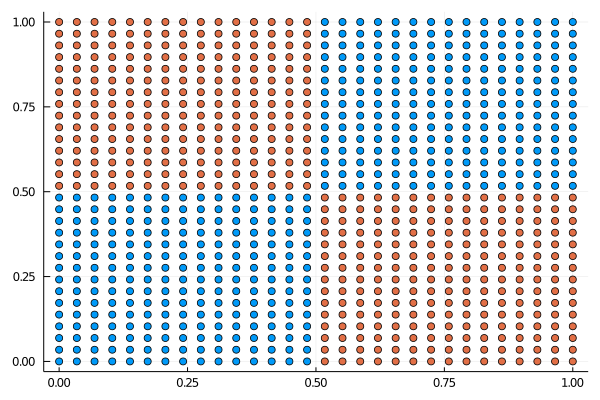

In [7]:
# One-hot encoding
# [1,0] represents xor = 0
# [0,1] represents xor = 1
to_xor_onehot(x1, x2) = ifelse((round(Int, x1) ⊻ round(Int, x2)) == 0, [1f0;0f0], [0f0;1f0]) 
domain = range(0f0, stop=1f0, length=30)
dataset = vec([([x1, x2], to_xor_onehot(x1, x2)) for x1 in domain, x2 in domain])
scatter(map(x->x[1][1], dataset), map(x->x[1][2], dataset), color=map(x -> ifelse(x[2] == [1f0;0f0], 1, 2), dataset), legend=false)

In [10]:
prepared_dataset_x = hcat(map(x->Float32.(x[1]), dataset)...)
prepared_dataset_y = hcat(map(x->Float32.(x[2]), dataset)...)

println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float32, [2,40,2,2]);

println("Prediction ")
ZeroAllocationNN.predict(zann, prepared_dataset_x)
@time ZeroAllocationNN.predict(zann, prepared_dataset_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);
@time ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);

Network creation 
  0.000032 seconds (18 allocations: 2.375 KiB)
Prediction 
  0.000485 seconds (8 allocations: 310.156 KiB)
Backpropagation 
  0.002346 seconds (42 allocations: 475.688 KiB)


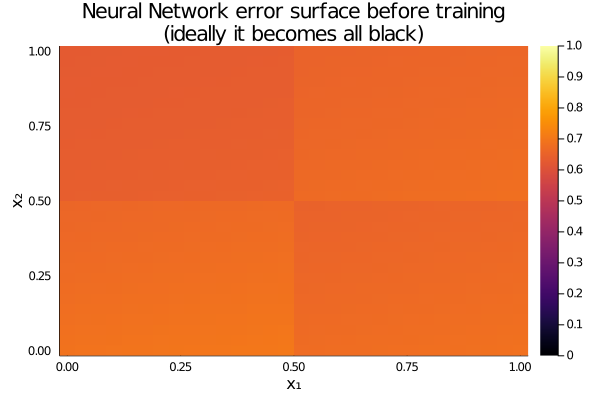

In [11]:
heatmap(
    domain,
    domain,
    (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - to_xor_onehot(x1, x2)).^2),
    title="Neural Network error surface before training\n(ideally it becomes all black)",
    xlabel="x₁",
    ylabel="x₂",
    clims=(0, 1)
)

### STOCHASTIC GRADIENT DESCENT (minibatch_size = 16)

In [67]:
function accuracy(y_true, y_pred)
    mask = (==).([p for p in eachcol(y_true)], [p for p in eachcol(y_pred)])
    return sum(mask) / length(mask)
end

accuracy (generic function with 1 method)

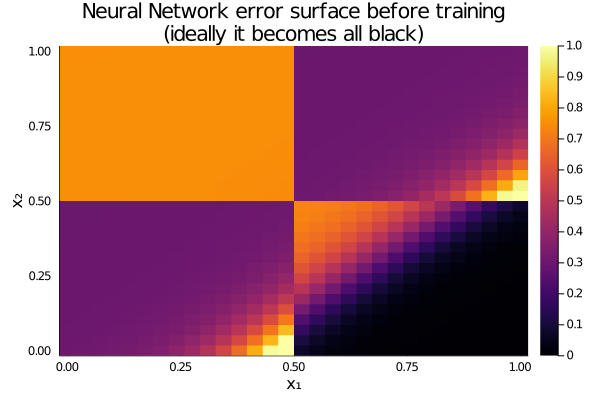

  6.712348 seconds (11.88 M allocations: 1.429 GiB, 4.55% gc time)
  

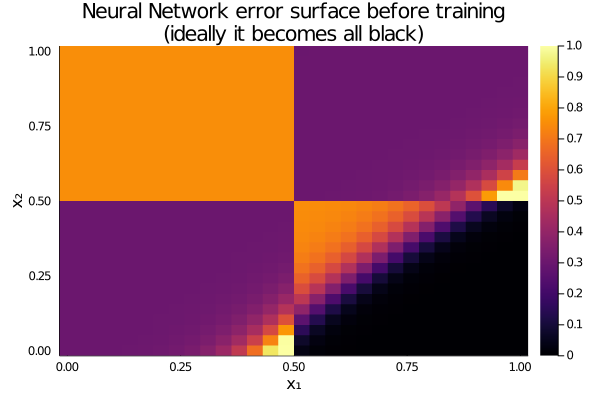

4.165847 seconds (7.59 M allocations: 1.219 GiB, 5.04% gc time)


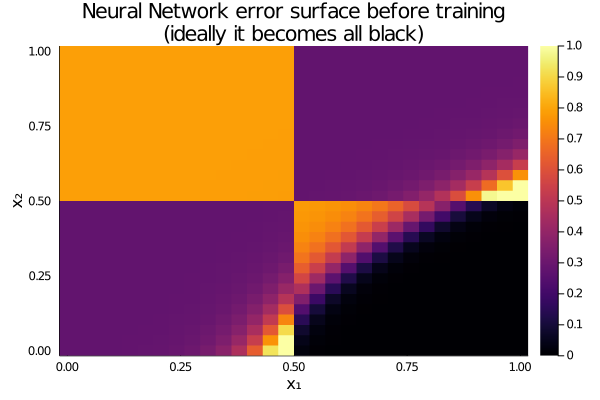

  4.201865 seconds (7.59 M allocations: 1.219 GiB, 5.36% gc time)
  

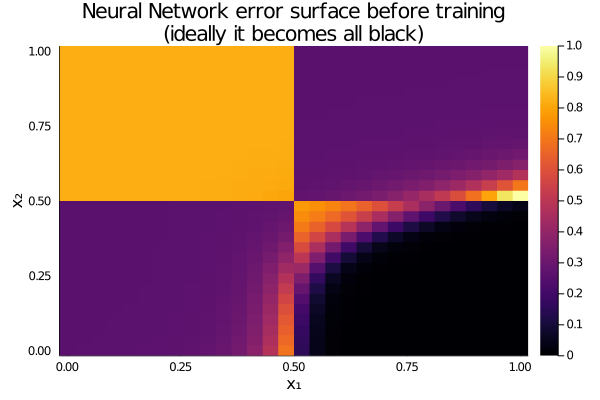

4.066615 seconds (7.59 M allocations: 1.219 GiB, 4.99% gc time)


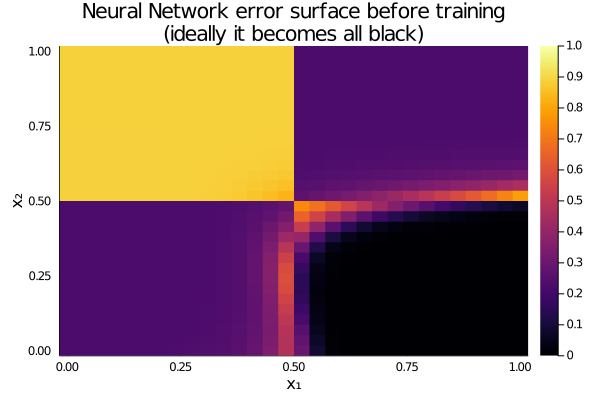

  4.190176 seconds (7.59 M allocations: 1.219 GiB, 5.01% gc time)
  

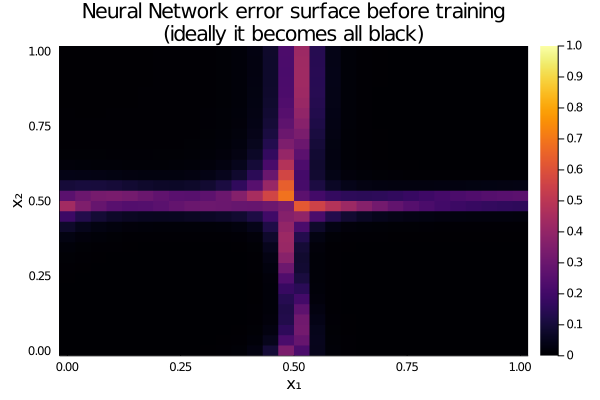

4.102081 seconds (7.59 M allocations: 1.219 GiB, 5.05% gc time)


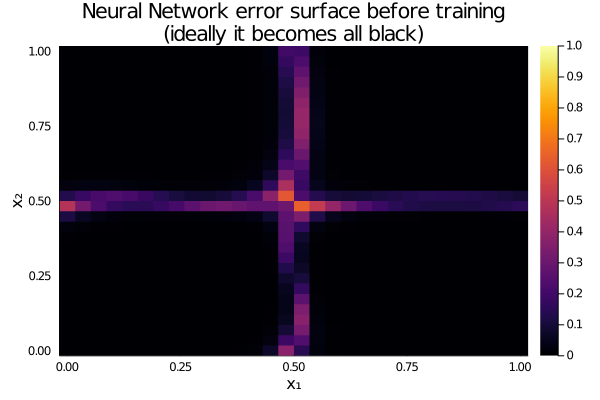

  4.110545 seconds (7.59 M allocations: 1.219 GiB, 5.20% gc time)
  

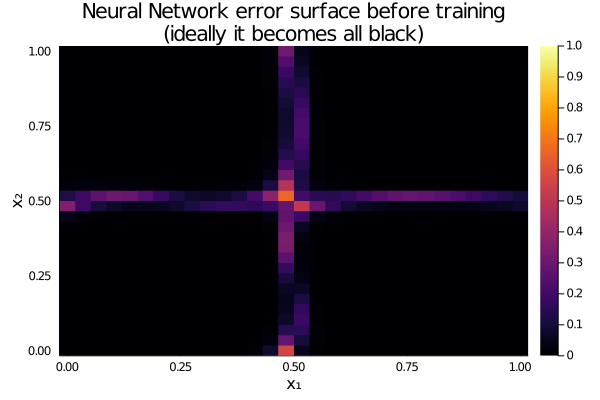

4.235356 seconds (7.59 M allocations: 1.219 GiB, 5.19% gc time)


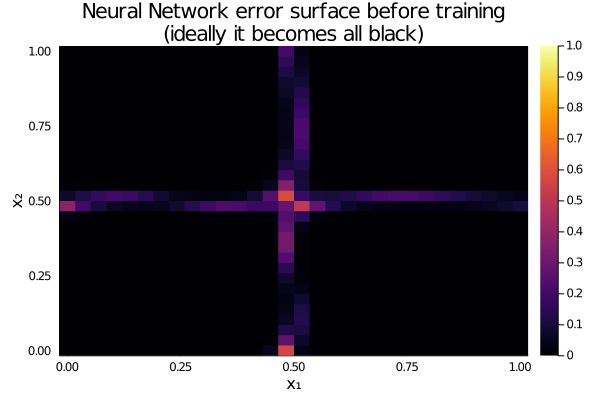

  4.265377 seconds (7.59 M allocations: 1.219 GiB, 5.16% gc time)
  

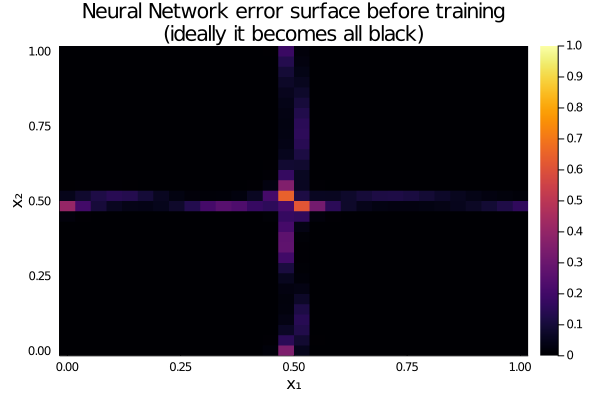

4.323203 seconds (7.59 M allocations: 1.219 GiB, 4.96% gc time)


In [13]:
epochs = 60_000
minibatch_size = 10
eta = 0.05

accuracies = Vector{Float64}()

for _ in 1:10
    @time for epoch in 1:epochs 
        # Obtain minibatch
        minibatch = rand(dataset, minibatch_size)
        x = hcat(map(x->x[1], minibatch)...)
        y = hcat(map(x->Float32.(x[2]), minibatch)...)
        
        # Obtain gradient vectors with backpropagation
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

        # Average the gradients of each datum in the minibatch
        nabla_ws = delta_nabla_ws / minibatch_size
        nabla_bs = delta_nabla_bs / minibatch_size

        # Perform gradient descent using the gradients
        zann.weights -= (eta * nabla_ws)
        zann.biases -= (eta * nabla_bs)
        
        # Calculate accuracy
        if epoch % 1_000 == 0
            # run the predictions over the whole training dataset
            predictions = ZeroAllocationNN.predict(zann, prepared_dataset_x)

            # transform the predictions into onehot vectors
            for j in axes(predictions, 2)
                predictions[:, j] = ifelse(predictions[:, j][1] > predictions[:, j][2], [1f0; 0f0], [0f0, 1f0])
            end
            
            push!(accuracies, accuracy(prepared_dataset_y, predictions))
        end
    end

    display(heatmap(
        domain,
        domain,
        (x1, x2) -> sum((ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :)) - to_xor_onehot(x1, x2)).^2),
        title="Neural Network error surface before training\n(ideally it becomes all black)",
        xlabel="x₁",
        ylabel="x₂",
        clims=(0, 1)
    ))
end

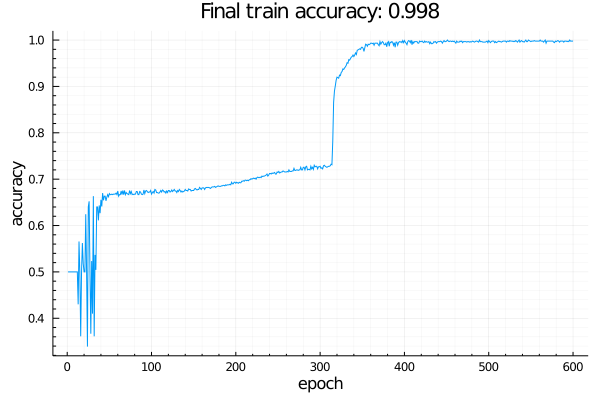

In [23]:
plot(accuracies, xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5, title="Final train accuracy: $(round(accuracies[end], digits=3))", label=false)

In [24]:
for (x1, x2) in ((0.1f0,0.2f0), (0.9f0,0.8f0), (0.1f0, 0.7f0), (0.9f0, 0.2f0))
    predicted = ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))
    expected = ifelse((round(Int, x1) ⊻ round(Int, x2)) == 0, [1f0;0f0], [0f0;1f0])
    println("($x1, $x2) => $(round.(predicted,digits=3)) - $expected")
end

(0.1, 0.2) => Float32[0.999; 0.001] - Float32[1.0, 0.0]
(0.9, 0.8) => Float32[0.999; 0.001] - Float32[1.0, 0.0]
(0.1, 0.7) => Float32[0.007; 0.993] - Float32[0.0, 1.0]
(0.9, 0.2) => Float32[0.005; 0.995] - Float32[0.0, 1.0]


---

## MNIST

In [96]:
using MLDatasets

In [97]:
using ImageCore

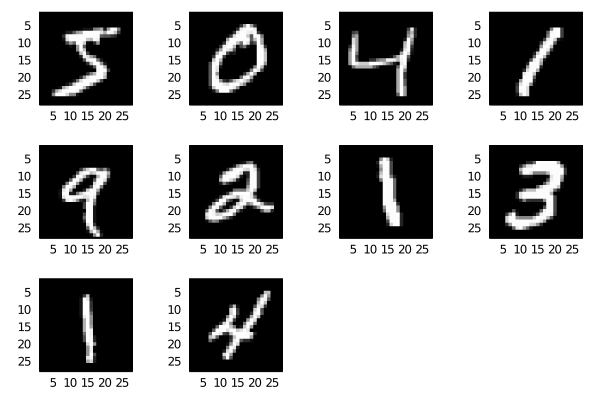

In [98]:
plot([plot(MNIST.convert2image(MNIST.traintensor(i))) for i in 1:10]...)

In [99]:
function to_mnist_onehot(y)
    v = zeros(10)
    v[y+1] = 1.0
    return v
end

to_mnist_onehot (generic function with 1 method)

In [100]:
prepared_mnist_x = reshape(MNIST.traintensor(Float64), 784, :)
prepared_mnist_y = hcat(map(to_mnist_onehot, MNIST.trainlabels())...)

prepared_mnist_x_test = reshape(MNIST.testtensor(Float64), 784, :)
prepared_mnist_y_test = hcat(map(to_mnist_onehot, MNIST.testlabels())...);

In [101]:
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN(Float64, [784,100,20,10]);

println("Prediction (expected allocations: $(Base.summarysize(randn(784,60000)) + Base.summarysize(randn(100,60000)) + Base.summarysize(randn(20,60000)) + Base.summarysize(randn(10,60000))))")
ZeroAllocationNN.predict(zann, prepared_mnist_x[:,1:10])
@time ZeroAllocationNN.predict(zann, prepared_mnist_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_mnist_x[:,1:10], prepared_mnist_y[:,1:10]);
@time ZeroAllocationNN.backprop(zann, prepared_mnist_x, prepared_mnist_y);

Network creation 
  0.000467 seconds (19 allocations: 632.438 KiB)
Prediction (expected allocations: 438720160)
  0.685329 seconds (12 allocations: 119.019 MiB)
Backpropagation 
  8.652366 seconds (51 allocations: 184.340 MiB)


In [102]:
predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x_test)

for j in axes(predictions, 2)
    predictions[:, j] = to_mnist_onehot(argmax(vec(predictions[:, j]))-1)
end

println("Initial test accuracy: $(round(accuracy(prepared_mnist_y_test, predictions), digits=4)) ≈ 0.1 expected")

Initial test accuracy: 0.1026 ≈ 0.1 expected


In [103]:
using TimerOutputs

In [104]:
epochs = 10_000
minibatch_size = 16
eta = 1e-0

accuracies = Vector{Float64}()

reset_timer!()
@timeit "whole training loop" for epoch in 1:epochs 
    # Obtain minibatch
    minibatch_ixs = rand(1:size(prepared_mnist_y, 2), minibatch_size)
    x = prepared_mnist_x[:, minibatch_ixs]
    y = prepared_mnist_y[:, minibatch_ixs]

    # Obtain gradient vectors with backpropagation
    @timeit "backprop step" delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

    # Average the gradients of each datum in the minibatch
    nabla_ws = delta_nabla_ws / minibatch_size
    nabla_bs = delta_nabla_bs / minibatch_size

    # Perform gradient descent using the gradients
    zann.weights -= (eta * nabla_ws)
    zann.biases -= (eta * nabla_bs)

    # Calculate accuracy
    @timeit "accuracy calculation" if epoch % 100 == 0
        predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x)
        
        for j in axes(predictions, 2)
            predictions[:, j] = to_mnist_onehot(argmax(vec(predictions[:, j]))-1)
        end
        
        acc = accuracy(prepared_mnist_y, predictions)
        println(acc)
        push!(accuracies, acc)
    end
end
print_timer()

0.22498333333333334
0.30196666666666666
0.3692666666666667
0.3950166666666667
0.4564
0.5183166666666666
0.55125
0.5823333333333334
0.6245666666666667
0.6474666666666666
0.6725666666666666
0.6952833333333334
0.7137666666666667
0.7363166666666666
0.7448
0.7502833333333333
0.7655166666666666
0.7761666666666667
0.7846
0.7936333333333333
0.7964833333333333
0.8029833333333334
0.8072833333333334
0.81185
0.8171166666666667
0.8206
0.8253
0.8299166666666666
0.83215
0.8335666666666667
0.8417
0.8440333333333333
0.8437333333333333
0.8460666666666666
0.8510833333333333
0.8492
0.8558333333333333
0.8599833333333333
0.8600166666666667
0.8632333333333333
0.8663
0.8639166666666667
0.8692
0.8690333333333333
0.87185
0.8729
0.8724666666666666
0.8754166666666666
0.87775
0.87555
0.8772166666666666
0.8804166666666666
0.8811666666666667
0.8845666666666666
0.87975
0.8858166666666667
0.88595
0.8843333333333333
0.8903833333333333
0.8905666666666666
0.89165
0.89195
0.8916166666666666
0.8931666666666667
0.8961833333

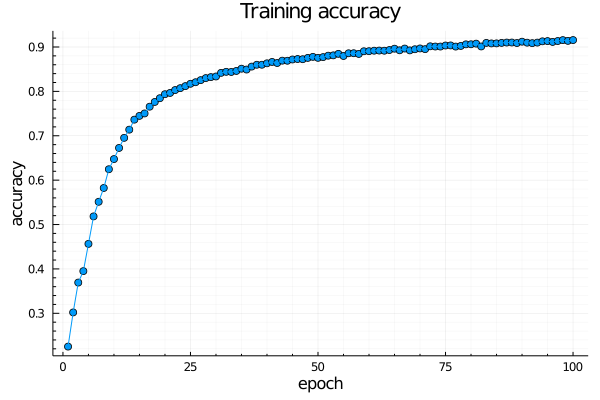

Final test accuracy: 0.9064


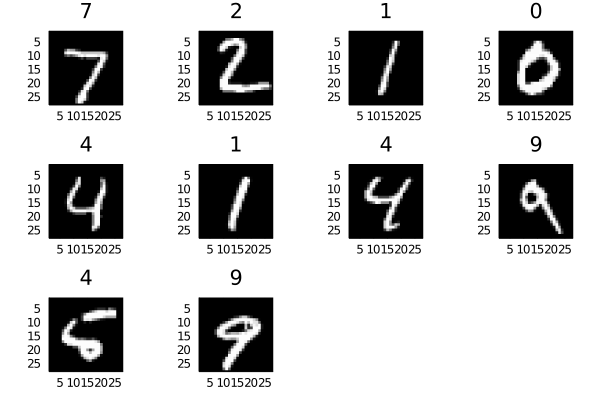

In [105]:
prepared_mnist_x_test = reshape(MNIST.testtensor(Float64), 784, :)
prepared_mnist_y_test = hcat(map(to_mnist_onehot, MNIST.testlabels())...)
predictions = ZeroAllocationNN.predict(zann, prepared_mnist_x_test)
for j in axes(predictions, 2)
            predictions[:, j] = to_mnist_onehot(argmax(vec(predictions[:, j]))-1)
end
println("Final test accuracy: $(round(accuracy(prepared_mnist_y_test, predictions), digits=6))")

scatter(
    accuracies,
    title="Training accuracy",
    label=false,
    xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5,
)
display(plot!(
    accuracies,
    c=1,
    label=false,
))

plot([
        plot(
            MNIST.convert2image(MNIST.testtensor(i)),
            title=argmax(predictions[:, i])-1
        )
        for i in 1:10
    ]...
)